# Resnet18 CIFAR-10

Quantize train resnet18 without PACT

In [1]:
NOQUANT_TRAIN = False
n_epochs = 200
batches = 1024

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt
import network.resnet_orig as resnet

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

model_names = sorted(name for name in resnet.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("resnet")
                     and callable(resnet.__dict__[name]))

DATA_DIR = "train"
print_freq = 50

# vit imsize
imsize = 32

In [3]:
# prepare labels
train_df = pd.read_csv("trainLabels.csv")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


In [4]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [5]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    albumentations.Rotate(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

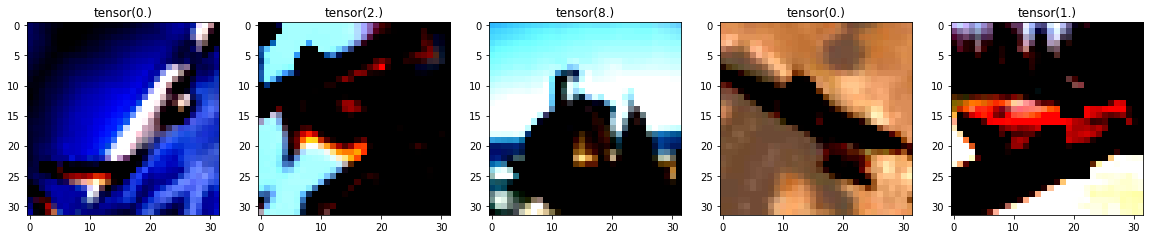

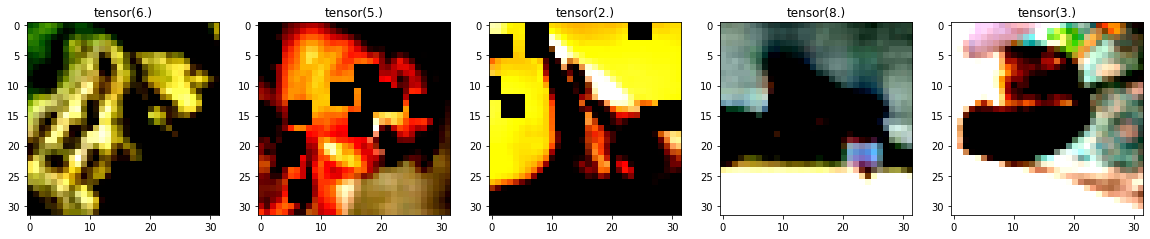

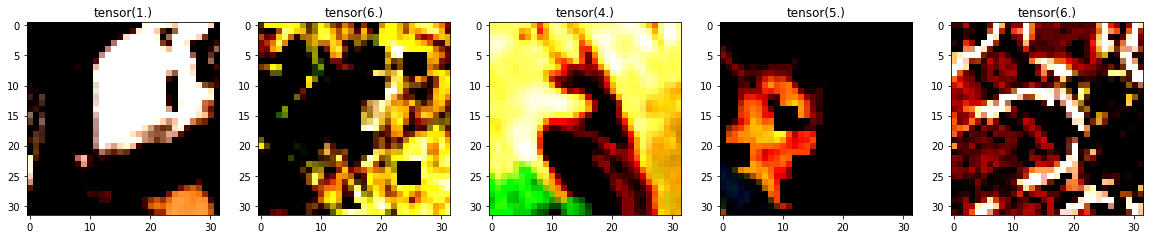

In [6]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [7]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(tqdm(train_loader)):

        # measure data loading time
        data_time.update(time.time() - end)
        target2 = target

        target = target.long().cuda()
        target2 = target2.long().cuda()
        input_var = input.cuda()
        target_var = target

        if not mixup:
          alpha = 0
        else:
          alpha = 1
        

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [8]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batches, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batches, shuffle=False,
    num_workers=8, pin_memory=True)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
from pact_utils import QuantizedLinear, QuantizedConv2d


def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, k=8, expansion=1):
        super(BasicBlock, self).__init__()
        self.k = k
        self.expansion = expansion
        self.conv1 = QuantizedConv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False, wbits=k, abits=k)
        self.bn1 = nn.BatchNorm2d(planes)
        # self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = QuantizedConv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False, wbits=k, abits=k)
        self.bn2 = nn.BatchNorm2d(planes)
        
        if stride != 1 or in_planes != planes:
              # original resnet shortcut
              self.shortcut = nn.Sequential(
                    # nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    QuantizedConv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False, wbits=k, abits=k),
                    nn.BatchNorm2d(self.expansion * planes)
              )
        else: # nothing done if stride or inplanes do not differ
          self.shortcut = nn.Sequential()

    def forward(self, x):
        # Relu is implemented as the input of conv2d
        out = self.bn1(self.conv1(x))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, K=8):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.k = K

        self.conv1 = QuantizedConv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False, abits=8, wbits=8)
        self.bn1 = nn.BatchNorm2d(32)
        self.alpha1 = nn.Parameter(torch.tensor(10.))
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=2, expansion=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2, expansion=1)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2, expansion=1)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2, expansion=1)

        # self.linear = nn.Linear(64, num_classes)
        self.linear = QuantizedLinear(256, num_classes, abits=8, wbits=8)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride, expansion):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.k, expansion))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        # out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn1(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, K=8):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = QuantizedConv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False, abits=8, wbits=8)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = QuantizedLinear(512*block.expansion, num_classes, abits=8, wbits=8)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out
    

def resnet20(k=8):
    print("bit width:", k)
    return ResNet(BasicBlock, [3, 3, 3, 3], K=k)

In [17]:
net = resnet20(8)
net.forward(torch.randn(1,3,32,32))

bit width: 8


tensor([[-0.4906, -1.5557,  0.2149,  0.1158, -0.8798, -0.1519,  0.5833, -0.4827,
          1.6052,  0.4414]], grad_fn=<AddmmBackward>)

# Train with quantization

In [ ]:
from timm.scheduler import CosineLRScheduler

for k in range(4,9):
    net = resnet20(k=k)

    model = net.cuda()
    mixup = False

    # Track experiment with wandb
    import wandb
    watermark = "resnet20_uniformquantize_bigger_k{}".format(k)

    # mess with wandb
    wandb.init(project="quantize_resnet", name=watermark)

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    # optimizer for pact
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                                momentum=0.9,
                                weight_decay=0.0002)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    scheduler = CosineLRScheduler(optimizer, t_initial=n_epochs, lr_min=1e-6, 
                          warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True)

    best_prec1 = 0
    os.makedirs("models", exist_ok=True)

    for epoch in range(n_epochs):
        scheduler.step(epoch)
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, criterion, optimizer, epoch)         

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model, criterion)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

bit width: 4


current lr 1.00000e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [0][0/40]	Time 4.430 (4.430)	Data 2.259 (2.259)	Loss 2.3751 (2.3751)	Prec@1 10.742 (10.742)
Test: [0/10]	Time 1.377 (1.377)	Loss 2.2309 (2.2309)	Prec@1 15.918 (15.918)
 * Prec@1 13.860
Best prec1 :  13.859999984741211
current lr 3.34000e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [1][0/40]	Time 3.167 (3.167)	Data 1.208 (1.208)	Loss 2.2707 (2.2707)	Prec@1 15.234 (15.234)
Test: [0/10]	Time 1.277 (1.277)	Loss 2.0500 (2.0500)	Prec@1 27.148 (27.148)
 * Prec@1 27.000
Best prec1 :  27.000000003051756
current lr 6.67000e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [2][0/40]	Time 4.829 (4.829)	Data 2.881 (2.881)	Loss 1.8767 (1.8767)	Prec@1 31.055 (31.055)
Test: [0/10]	Time 1.298 (1.298)	Loss 1.8604 (1.8604)	Prec@1 31.445 (31.445)
 * Prec@1 32.460
Best prec1 :  32.459999853515626
current lr 1.00000e-03


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [3][0/40]	Time 2.936 (2.936)	Data 1.223 (1.223)	Loss 1.7907 (1.7907)	Prec@1 33.984 (33.984)
Test: [0/10]	Time 1.436 (1.436)	Loss 1.8389 (1.8389)	Prec@1 32.910 (32.910)
 * Prec@1 34.900
Best prec1 :  34.89999991455078
current lr 9.99938e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [4][0/40]	Time 5.098 (5.098)	Data 3.135 (3.135)	Loss 1.7014 (1.7014)	Prec@1 36.035 (36.035)
Test: [0/10]	Time 1.307 (1.307)	Loss 1.7116 (1.7116)	Prec@1 38.574 (38.574)
 * Prec@1 39.440
Best prec1 :  39.439999871826174
current lr 9.99754e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [5][0/40]	Time 4.015 (4.015)	Data 2.235 (2.235)	Loss 1.6615 (1.6615)	Prec@1 38.379 (38.379)
Test: [0/10]	Time 1.368 (1.368)	Loss 1.5796 (1.5796)	Prec@1 43.848 (43.848)
 * Prec@1 43.300
Best prec1 :  43.30000002441406
current lr 9.99445e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [6][0/40]	Time 2.396 (2.396)	Data 1.199 (1.199)	Loss 1.5992 (1.5992)	Prec@1 43.066 (43.066)
Test: [0/10]	Time 1.105 (1.105)	Loss 1.6893 (1.6893)	Prec@1 38.379 (38.379)
 * Prec@1 39.530
Best prec1 :  43.30000002441406
current lr 9.99014e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [7][0/40]	Time 3.696 (3.696)	Data 1.878 (1.878)	Loss 1.5106 (1.5106)	Prec@1 42.480 (42.480)
Test: [0/10]	Time 1.517 (1.517)	Loss 1.3653 (1.3653)	Prec@1 51.758 (51.758)
 * Prec@1 49.840
Best prec1 :  49.83999985351562
current lr 9.98460e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [8][0/40]	Time 2.521 (2.521)	Data 1.594 (1.594)	Loss 1.4760 (1.4760)	Prec@1 47.168 (47.168)
Test: [0/10]	Time 1.534 (1.534)	Loss 1.6457 (1.6457)	Prec@1 43.359 (43.359)
 * Prec@1 44.030
Best prec1 :  49.83999985351562
current lr 9.97783e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [9][0/40]	Time 3.748 (3.748)	Data 1.743 (1.743)	Loss 1.3913 (1.3913)	Prec@1 48.730 (48.730)
Test: [0/10]	Time 1.242 (1.242)	Loss 1.5081 (1.5081)	Prec@1 45.801 (45.801)
 * Prec@1 45.160
Best prec1 :  49.83999985351562
current lr 9.96983e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [10][0/40]	Time 3.626 (3.626)	Data 2.033 (2.033)	Loss 1.3836 (1.3836)	Prec@1 48.633 (48.633)
Test: [0/10]	Time 1.561 (1.561)	Loss 1.3510 (1.3510)	Prec@1 51.465 (51.465)
 * Prec@1 51.270
Best prec1 :  51.27000001220703
current lr 9.96061e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [11][0/40]	Time 4.198 (4.198)	Data 2.652 (2.652)	Loss 1.3726 (1.3726)	Prec@1 50.195 (50.195)
Test: [0/10]	Time 1.597 (1.597)	Loss 1.3546 (1.3546)	Prec@1 51.465 (51.465)
 * Prec@1 51.140
Best prec1 :  51.27000001220703
current lr 9.95017e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [12][0/40]	Time 3.524 (3.524)	Data 1.634 (1.634)	Loss 1.3581 (1.3581)	Prec@1 49.121 (49.121)
Test: [0/10]	Time 1.017 (1.017)	Loss 1.4555 (1.4555)	Prec@1 51.270 (51.270)
 * Prec@1 49.840
Best prec1 :  51.27000001220703
current lr 9.93850e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [13][0/40]	Time 3.756 (3.756)	Data 2.268 (2.268)	Loss 1.3644 (1.3644)	Prec@1 51.270 (51.270)
Test: [0/10]	Time 1.448 (1.448)	Loss 1.1571 (1.1571)	Prec@1 57.910 (57.910)
 * Prec@1 55.540
Best prec1 :  55.54000005493164
current lr 9.92562e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [14][0/40]	Time 2.250 (2.250)	Data 1.240 (1.240)	Loss 1.2833 (1.2833)	Prec@1 52.539 (52.539)
Test: [0/10]	Time 1.303 (1.303)	Loss 1.2935 (1.2935)	Prec@1 53.809 (53.809)
 * Prec@1 51.850
Best prec1 :  55.54000005493164
current lr 9.91152e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [15][0/40]	Time 4.375 (4.375)	Data 2.412 (2.412)	Loss 1.2410 (1.2410)	Prec@1 55.371 (55.371)
Test: [0/10]	Time 1.348 (1.348)	Loss 1.2667 (1.2667)	Prec@1 54.395 (54.395)
 * Prec@1 54.570
Best prec1 :  55.54000005493164
current lr 9.89622e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [16][0/40]	Time 2.957 (2.957)	Data 1.598 (1.598)	Loss 1.2465 (1.2465)	Prec@1 54.883 (54.883)
Test: [0/10]	Time 1.051 (1.051)	Loss 1.1760 (1.1760)	Prec@1 58.496 (58.496)
 * Prec@1 56.590
Best prec1 :  56.589999896240236
current lr 9.87970e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [17][0/40]	Time 4.255 (4.255)	Data 2.230 (2.230)	Loss 1.2219 (1.2219)	Prec@1 54.688 (54.688)
Test: [0/10]	Time 1.306 (1.306)	Loss 1.0590 (1.0590)	Prec@1 61.523 (61.523)
 * Prec@1 60.240
Best prec1 :  60.23999987792969
current lr 9.86199e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [18][0/40]	Time 3.694 (3.694)	Data 2.637 (2.637)	Loss 1.1459 (1.1459)	Prec@1 58.887 (58.887)
Test: [0/10]	Time 1.455 (1.455)	Loss 1.2286 (1.2286)	Prec@1 56.250 (56.250)
 * Prec@1 54.760
Best prec1 :  60.23999987792969
current lr 9.84307e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [19][0/40]	Time 2.691 (2.691)	Data 1.922 (1.922)	Loss 1.1371 (1.1371)	Prec@1 57.715 (57.715)
Test: [0/10]	Time 0.997 (0.997)	Loss 0.9343 (0.9343)	Prec@1 65.527 (65.527)
 * Prec@1 63.740
Best prec1 :  63.740000024414066
current lr 9.82296e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [20][0/40]	Time 4.001 (4.001)	Data 1.970 (1.970)	Loss 1.0757 (1.0757)	Prec@1 61.816 (61.816)
Test: [0/10]	Time 1.406 (1.406)	Loss 0.9538 (0.9538)	Prec@1 65.625 (65.625)
 * Prec@1 63.700
Best prec1 :  63.740000024414066
current lr 9.80167e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [21][0/40]	Time 4.370 (4.370)	Data 2.402 (2.402)	Loss 1.0766 (1.0766)	Prec@1 60.840 (60.840)
Test: [0/10]	Time 1.379 (1.379)	Loss 1.1814 (1.1814)	Prec@1 59.375 (59.375)
 * Prec@1 56.840
Best prec1 :  63.740000024414066
current lr 9.77919e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [22][0/40]	Time 2.833 (2.833)	Data 1.105 (1.105)	Loss 1.1414 (1.1414)	Prec@1 59.668 (59.668)
Test: [0/10]	Time 1.365 (1.365)	Loss 1.0071 (1.0071)	Prec@1 63.770 (63.770)
 * Prec@1 62.000
Best prec1 :  63.740000024414066
current lr 9.75553e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [23][0/40]	Time 3.676 (3.676)	Data 1.853 (1.853)	Loss 1.0307 (1.0307)	Prec@1 64.551 (64.551)
Test: [0/10]	Time 1.268 (1.268)	Loss 1.0217 (1.0217)	Prec@1 64.551 (64.551)
 * Prec@1 62.790
Best prec1 :  63.740000024414066
current lr 9.73070e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [24][0/40]	Time 3.376 (3.376)	Data 2.203 (2.203)	Loss 1.0120 (1.0120)	Prec@1 62.891 (62.891)
Test: [0/10]	Time 1.594 (1.594)	Loss 0.8841 (0.8841)	Prec@1 70.020 (70.020)
 * Prec@1 67.140
Best prec1 :  67.13999998779298
current lr 9.70470e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [25][0/40]	Time 2.723 (2.723)	Data 1.364 (1.364)	Loss 0.9217 (0.9217)	Prec@1 67.871 (67.871)
Test: [0/10]	Time 0.993 (0.993)	Loss 0.9211 (0.9211)	Prec@1 66.406 (66.406)
 * Prec@1 66.030
Best prec1 :  67.13999998779298
current lr 9.67754e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [26][0/40]	Time 4.538 (4.538)	Data 2.585 (2.585)	Loss 1.0046 (1.0046)	Prec@1 66.016 (66.016)
Test: [0/10]	Time 1.340 (1.340)	Loss 0.8377 (0.8377)	Prec@1 69.629 (69.629)
 * Prec@1 68.640
Best prec1 :  68.64000007324219
current lr 9.64923e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [27][0/40]	Time 2.543 (2.543)	Data 1.642 (1.642)	Loss 0.9148 (0.9148)	Prec@1 66.699 (66.699)
Test: [0/10]	Time 1.616 (1.616)	Loss 0.9631 (0.9631)	Prec@1 64.551 (64.551)
 * Prec@1 64.560
Best prec1 :  68.64000007324219
current lr 9.61978e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [28][0/40]	Time 3.839 (3.839)	Data 1.934 (1.934)	Loss 0.9535 (0.9535)	Prec@1 66.016 (66.016)
Test: [0/10]	Time 1.345 (1.345)	Loss 0.8823 (0.8823)	Prec@1 68.750 (68.750)
 * Prec@1 65.930
Best prec1 :  68.64000007324219
current lr 9.58918e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [29][0/40]	Time 4.060 (4.060)	Data 2.335 (2.335)	Loss 0.9104 (0.9104)	Prec@1 67.676 (67.676)
Test: [0/10]	Time 1.962 (1.962)	Loss 0.8833 (0.8833)	Prec@1 70.410 (70.410)
 * Prec@1 67.150
Best prec1 :  68.64000007324219
current lr 9.55746e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [30][0/40]	Time 3.716 (3.716)	Data 1.654 (1.654)	Loss 0.9196 (0.9196)	Prec@1 66.309 (66.309)
Test: [0/10]	Time 1.033 (1.033)	Loss 0.8150 (0.8150)	Prec@1 71.191 (71.191)
 * Prec@1 69.950
Best prec1 :  69.9500001953125
current lr 9.52461e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [31][0/40]	Time 5.108 (5.108)	Data 3.125 (3.125)	Loss 0.9125 (0.9125)	Prec@1 68.457 (68.457)
Test: [0/10]	Time 1.548 (1.548)	Loss 0.8626 (0.8626)	Prec@1 69.824 (69.824)
 * Prec@1 67.670
Best prec1 :  69.9500001953125
current lr 9.49065e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [32][0/40]	Time 3.253 (3.253)	Data 1.525 (1.525)	Loss 0.8828 (0.8828)	Prec@1 67.188 (67.188)
Test: [0/10]	Time 1.041 (1.041)	Loss 0.8088 (0.8088)	Prec@1 71.680 (71.680)
 * Prec@1 70.400
Best prec1 :  70.39999967041015
current lr 9.45558e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [33][0/40]	Time 4.212 (4.212)	Data 2.327 (2.327)	Loss 0.9047 (0.9047)	Prec@1 67.871 (67.871)
Test: [0/10]	Time 1.356 (1.356)	Loss 0.8028 (0.8028)	Prec@1 72.266 (72.266)
 * Prec@1 70.160
Best prec1 :  70.39999967041015
current lr 9.41941e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [34][0/40]	Time 3.232 (3.232)	Data 1.641 (1.641)	Loss 0.8941 (0.8941)	Prec@1 68.750 (68.750)
Test: [0/10]	Time 1.308 (1.308)	Loss 0.8429 (0.8429)	Prec@1 70.117 (70.117)
 * Prec@1 67.910
Best prec1 :  70.39999967041015
current lr 9.38215e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [35][0/40]	Time 3.489 (3.489)	Data 1.514 (1.514)	Loss 0.9193 (0.9193)	Prec@1 67.383 (67.383)
Test: [0/10]	Time 1.335 (1.335)	Loss 0.7487 (0.7487)	Prec@1 73.145 (73.145)
 * Prec@1 71.120
Best prec1 :  71.11999982910156
current lr 9.34381e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [36][0/40]	Time 4.566 (4.566)	Data 2.538 (2.538)	Loss 0.7912 (0.7912)	Prec@1 71.777 (71.777)
Test: [0/10]	Time 2.438 (2.438)	Loss 0.8603 (0.8603)	Prec@1 71.484 (71.484)
 * Prec@1 68.880
Best prec1 :  71.11999982910156
current lr 9.30441e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [37][0/40]	Time 3.411 (3.411)	Data 1.348 (1.348)	Loss 0.8332 (0.8332)	Prec@1 71.094 (71.094)
Test: [0/10]	Time 1.109 (1.109)	Loss 0.7377 (0.7377)	Prec@1 72.168 (72.168)
 * Prec@1 72.700
Best prec1 :  72.70000008544922
current lr 9.26394e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [38][0/40]	Time 4.465 (4.465)	Data 2.652 (2.652)	Loss 0.8951 (0.8951)	Prec@1 68.066 (68.066)
Test: [0/10]	Time 1.218 (1.218)	Loss 0.8330 (0.8330)	Prec@1 71.387 (71.387)
 * Prec@1 71.130
Best prec1 :  72.70000008544922
current lr 9.22242e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [39][0/40]	Time 3.768 (3.768)	Data 1.956 (1.956)	Loss 0.8425 (0.8425)	Prec@1 71.289 (71.289)
Test: [0/10]	Time 1.537 (1.537)	Loss 0.7524 (0.7524)	Prec@1 73.242 (73.242)
 * Prec@1 71.110
Best prec1 :  72.70000008544922
current lr 9.17986e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [40][0/40]	Time 2.610 (2.610)	Data 1.501 (1.501)	Loss 0.7706 (0.7706)	Prec@1 73.730 (73.730)
Test: [0/10]	Time 0.999 (0.999)	Loss 0.7517 (0.7517)	Prec@1 74.707 (74.707)
 * Prec@1 71.530
Best prec1 :  72.70000008544922
current lr 9.13627e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [41][0/40]	Time 4.212 (4.212)	Data 2.387 (2.387)	Loss 0.8151 (0.8151)	Prec@1 69.629 (69.629)
Test: [0/10]	Time 1.413 (1.413)	Loss 0.7766 (0.7766)	Prec@1 73.730 (73.730)
 * Prec@1 71.300
Best prec1 :  72.70000008544922
current lr 9.09166e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [42][0/40]	Time 2.620 (2.620)	Data 1.507 (1.507)	Loss 0.7469 (0.7469)	Prec@1 75.586 (75.586)
Test: [0/10]	Time 1.348 (1.348)	Loss 0.7386 (0.7386)	Prec@1 74.512 (74.512)
 * Prec@1 73.950
Best prec1 :  73.95000006103515
current lr 9.04604e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [43][0/40]	Time 3.971 (3.971)	Data 1.928 (1.928)	Loss 0.8016 (0.8016)	Prec@1 71.387 (71.387)
Test: [0/10]	Time 1.141 (1.141)	Loss 0.7010 (0.7010)	Prec@1 77.246 (77.246)
 * Prec@1 73.510
Best prec1 :  73.95000006103515
current lr 8.99942e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [44][0/40]	Time 5.069 (5.069)	Data 3.169 (3.169)	Loss 0.7801 (0.7801)	Prec@1 71.484 (71.484)
Test: [0/10]	Time 1.598 (1.598)	Loss 0.8070 (0.8070)	Prec@1 70.801 (70.801)
 * Prec@1 70.190
Best prec1 :  73.95000006103515
current lr 8.95182e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [45][0/40]	Time 2.451 (2.451)	Data 1.527 (1.527)	Loss 0.7217 (0.7217)	Prec@1 74.316 (74.316)
Test: [0/10]	Time 1.682 (1.682)	Loss 0.7205 (0.7205)	Prec@1 74.414 (74.414)
 * Prec@1 73.180
Best prec1 :  73.95000006103515
current lr 8.90325e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [46][0/40]	Time 3.622 (3.622)	Data 1.625 (1.625)	Loss 0.7493 (0.7493)	Prec@1 74.316 (74.316)
Test: [0/10]	Time 1.499 (1.499)	Loss 0.6572 (0.6572)	Prec@1 76.855 (76.855)
 * Prec@1 76.090
Best prec1 :  76.08999991455079
current lr 8.85371e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [47][0/40]	Time 2.752 (2.752)	Data 1.689 (1.689)	Loss 0.7452 (0.7452)	Prec@1 73.926 (73.926)
Test: [0/10]	Time 1.605 (1.605)	Loss 0.6573 (0.6573)	Prec@1 75.684 (75.684)
 * Prec@1 75.060
Best prec1 :  76.08999991455079
current lr 8.80323e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [48][0/40]	Time 3.504 (3.504)	Data 1.514 (1.514)	Loss 0.7034 (0.7034)	Prec@1 74.805 (74.805)
Test: [0/10]	Time 1.437 (1.437)	Loss 0.6786 (0.6786)	Prec@1 75.879 (75.879)
 * Prec@1 74.890
Best prec1 :  76.08999991455079
current lr 8.75180e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [49][0/40]	Time 4.387 (4.387)	Data 2.440 (2.440)	Loss 0.8010 (0.8010)	Prec@1 71.094 (71.094)
Test: [0/10]	Time 2.254 (2.254)	Loss 0.6771 (0.6771)	Prec@1 77.344 (77.344)
 * Prec@1 75.270
Best prec1 :  76.08999991455079
current lr 8.69946e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [50][0/40]	Time 4.492 (4.492)	Data 2.747 (2.747)	Loss 0.6927 (0.6927)	Prec@1 75.586 (75.586)
Test: [0/10]	Time 1.442 (1.442)	Loss 0.7265 (0.7265)	Prec@1 74.316 (74.316)
 * Prec@1 74.460
Best prec1 :  76.08999991455079
current lr 8.64620e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [51][0/40]	Time 2.554 (2.554)	Data 1.351 (1.351)	Loss 0.7321 (0.7321)	Prec@1 74.707 (74.707)
Test: [0/10]	Time 1.025 (1.025)	Loss 0.6533 (0.6533)	Prec@1 76.270 (76.270)
 * Prec@1 76.160
Best prec1 :  76.15999985351563
current lr 8.59204e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [52][0/40]	Time 3.843 (3.843)	Data 2.029 (2.029)	Loss 0.7136 (0.7136)	Prec@1 75.000 (75.000)
Test: [0/10]	Time 1.402 (1.402)	Loss 0.7007 (0.7007)	Prec@1 76.465 (76.465)
 * Prec@1 74.690
Best prec1 :  76.15999985351563
current lr 8.53700e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [53][0/40]	Time 2.997 (2.997)	Data 1.672 (1.672)	Loss 0.6872 (0.6872)	Prec@1 75.781 (75.781)
Test: [0/10]	Time 1.351 (1.351)	Loss 0.6556 (0.6556)	Prec@1 75.879 (75.879)
 * Prec@1 76.910
Best prec1 :  76.9100002319336
current lr 8.48108e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [54][0/40]	Time 3.806 (3.806)	Data 1.750 (1.750)	Loss 0.7492 (0.7492)	Prec@1 74.121 (74.121)
Test: [0/10]	Time 1.295 (1.295)	Loss 0.6383 (0.6383)	Prec@1 76.562 (76.562)
 * Prec@1 76.980
Best prec1 :  76.97999973144532
current lr 8.42431e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [55][0/40]	Time 4.547 (4.547)	Data 2.603 (2.603)	Loss 0.7012 (0.7012)	Prec@1 75.879 (75.879)
Test: [0/10]	Time 1.502 (1.502)	Loss 0.6789 (0.6789)	Prec@1 77.441 (77.441)
 * Prec@1 75.230
Best prec1 :  76.97999973144532
current lr 8.36670e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [56][0/40]	Time 3.348 (3.348)	Data 1.663 (1.663)	Loss 0.6751 (0.6751)	Prec@1 77.051 (77.051)
Test: [0/10]	Time 0.989 (0.989)	Loss 0.6049 (0.6049)	Prec@1 79.199 (79.199)
 * Prec@1 77.870
Best prec1 :  77.87000018310547
current lr 8.30825e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [57][0/40]	Time 4.542 (4.542)	Data 2.494 (2.494)	Loss 0.6309 (0.6309)	Prec@1 78.223 (78.223)
Test: [0/10]	Time 1.025 (1.025)	Loss 0.6528 (0.6528)	Prec@1 76.660 (76.660)
 * Prec@1 75.790
Best prec1 :  77.87000018310547
current lr 8.24899e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [58][0/40]	Time 4.233 (4.233)	Data 2.437 (2.437)	Loss 0.6606 (0.6606)	Prec@1 76.855 (76.855)
Test: [0/10]	Time 1.677 (1.677)	Loss 0.6179 (0.6179)	Prec@1 78.711 (78.711)
 * Prec@1 77.450
Best prec1 :  77.87000018310547
current lr 8.18893e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [59][0/40]	Time 2.513 (2.513)	Data 1.233 (1.233)	Loss 0.6813 (0.6813)	Prec@1 75.488 (75.488)
Test: [0/10]	Time 1.446 (1.446)	Loss 0.6567 (0.6567)	Prec@1 77.539 (77.539)
 * Prec@1 76.850
Best prec1 :  77.87000018310547
current lr 8.12809e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [60][0/40]	Time 3.984 (3.984)	Data 2.041 (2.041)	Loss 0.6054 (0.6054)	Prec@1 78.809 (78.809)
Test: [0/10]	Time 1.384 (1.384)	Loss 0.6285 (0.6285)	Prec@1 79.004 (79.004)
 * Prec@1 77.790
Best prec1 :  77.87000018310547
current lr 8.06647e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [61][0/40]	Time 2.893 (2.893)	Data 1.735 (1.735)	Loss 0.6588 (0.6588)	Prec@1 77.344 (77.344)
Test: [0/10]	Time 1.110 (1.110)	Loss 0.6430 (0.6430)	Prec@1 78.125 (78.125)
 * Prec@1 77.300
Best prec1 :  77.87000018310547
current lr 8.00410e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [62][0/40]	Time 4.367 (4.367)	Data 2.291 (2.291)	Loss 0.6581 (0.6581)	Prec@1 76.465 (76.465)
Test: [0/10]	Time 1.367 (1.367)	Loss 0.6378 (0.6378)	Prec@1 77.051 (77.051)
 * Prec@1 76.940
Best prec1 :  77.87000018310547
current lr 7.94099e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [63][0/40]	Time 4.693 (4.693)	Data 2.716 (2.716)	Loss 0.6397 (0.6397)	Prec@1 78.516 (78.516)


In [ ]:
from pact_utils import TorchQuantize
len(TorchQuantize(bits=4).forward(torch.rand(1,384)).unique())

In [ ]:
net.blocks[1].mlp.fc1.forward(torch.rand(1,384).cuda()).unique()

In [ ]:
model.blocks[1].attn.qkv